## OVERVIEW
---
* Visualize the Distribution of Open Stock Price
* Seasonal Decomposition to See the Trend
* Forecast the Next 30 Days by Using Different Baseline Models
* Gradient Boosting With Hyperparameter Tuning
* Comparisson Between Classical Statistics Method of Forecasting and Machine Learning Baseline Models

In [1]:
#VIZ AND DATA MANIPULATION LIBRARY
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
init_notebook_mode(connected = True)
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


#Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import uniform

#MODELS
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.gaussian_process import GaussianProcessClassifier
from bayes_opt import BayesianOptimization


#CLASSICAL STATS
import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox


#DEEP LEARNING LIB
from keras.models import Model,Sequential
from keras.optimizers import SGD,Adadelta,Adam,RMSprop 
from keras.utils import np_utils, to_categorical
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import itertools
import lightgbm as lgb



#METRICS
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, r2_score,mean_absolute_error,mean_squared_error

from random import randrange
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\Wendell\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

Using TensorFlow backend.


In [2]:
#get the data
df = pd.read_csv('data/apple_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

#Removing '$' symbol on the open price
SYMBOLS = '{}()[],:;+-*/$' 
results = []
for element in df[' Open'].values:
    temp = ""
    for ch in element:
        if ch not in SYMBOLS:
            temp += ch

    results.append(np.float64(temp))

df[' Open'] = np.array(results)

#extracting date
df['day'] = df['Date'].dt.day
df['week'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['Date'] = df['Date'].dt.date


df_train = df[[' Open', 'day','week','month','year']][:-30]
df_test = df[[' Open', 'day','week','month','year']][-30:]

#I will only forecast the open stock price for the last 30 days, i will set aside the rest of the columns

### DATA BASIC INFORMATION
---

In [3]:
print('Minimum Price:  ', df_train[' Open'].min(), '$')
print('Maximum Price:  ', df_train[' Open'].max(), '$')
print('Price Mean:   ', df_train[' Open'].values.mean(), '$')
print('Price Median:   ', df_train[' Open'].median(), '$')

Minimum Price:   29.3928 $
Maximum Price:   316.7 $
Price Mean:    112.33837439710612 $
Price Median:    100.36715000000001 $


In [4]:
print('Train Set Shape:  ',df_train.shape)
print('Test Set Shape:  ',df_test.shape)

Train Set Shape:   (2488, 5)
Test Set Shape:   (30, 5)


### SALES DISTRIBUTION
---

In [7]:
#dividing the prices to seven range categories
price_distribution = pd.DataFrame(df_train.copy())
price_distribution['range'] = pd.cut(price_distribution[' Open'], [0,50,100,150,200,250,300,350]).values
price_distribution = price_distribution.groupby('range')[' Open'].count()

Text(0, 0.5, 'Count')

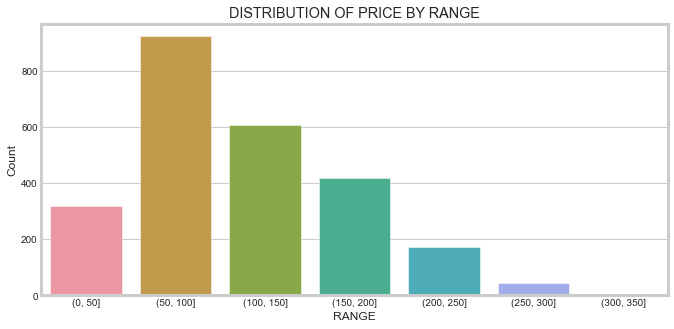

In [8]:
plt.figure(figsize=(10,5))
sns.barplot(x=price_distribution.index, y=price_distribution.values)
plt.title('DISTRIBUTION OF PRICE BY RANGE')
plt.xlabel('RANGE')
plt.ylabel('Count')

Text(0, 0.5, 'PERCENTAGE')

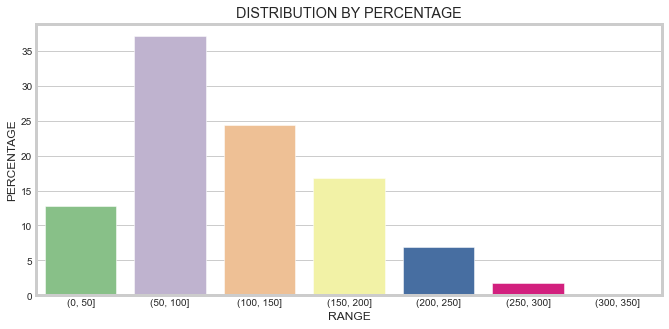

In [9]:
price_distribution_perc = price_distribution.values / price_distribution.values.sum() *100

plt.figure(figsize=(10,5))
sns.barplot(x=price_distribution.index, y=price_distribution_perc, palette='Accent')
plt.title('DISTRIBUTION BY PERCENTAGE')
plt.xlabel('RANGE')
plt.ylabel('PERCENTAGE')

Text(0.5, 1.0, 'DISTRIBUTION OF PRICE')

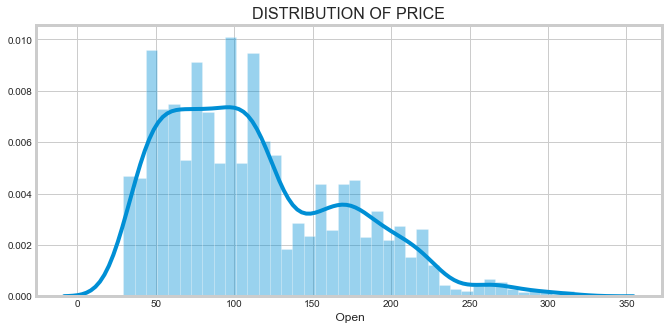

In [10]:
plt.figure(figsize=(10,5))
sns.distplot(df_train[' Open'], bins=40)
plt.title('DISTRIBUTION OF PRICE', fontsize=16)

* FROM THE DISTRIBUTION GRAPH ABOVE, WE CAN CLEARLY SEE THAT 61% OF THE PRICE IS FROM 50USD - 60USD WITH A POSITIVE SKEW.


Text(0, 0.5, 'Price')

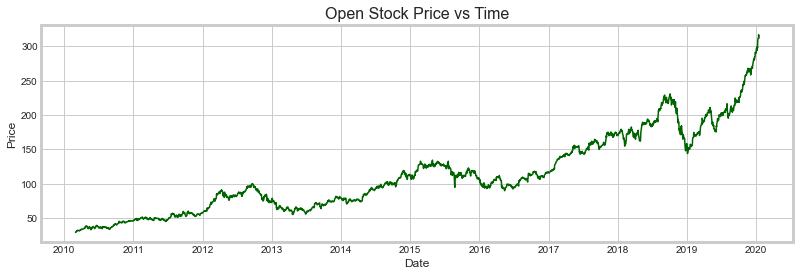

In [11]:
#Show fig time-series open open stock price
plt.figure(figsize=(12,4))
sns.lineplot(x = df['Date'][:-30], y=df_train[' Open'].values, color='darkgreen', lw=1.5)
plt.title('Open Stock Price vs Time', fontsize=16)
plt.ylabel('Price', fontsize=12)

* AS WE CAN SEE, A SPAN OF 10 YEARS THE OPEN STOCK PRICE GOES UP
* LET'S DECOMPOSE THE SIGNAL BY SEASONALITY SO WE CAN VISUALIZE THE TREND 

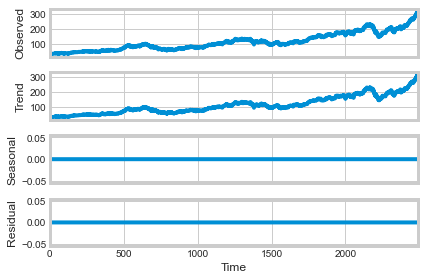

In [15]:
#applying seasonal decomposition on the timeseries data
dec = seasonal_decompose(df_train[' Open'].to_list(), freq=1, model='additive')
dec.plot()
pyplot.show()

* FROM THE PLOT ABOVE, WE CAN SEE THAT THE ENTIRE SERIES WAS TAKEN AS THE TREND COMPONENT AND THAT THERE WAS NO SEASONALITY.
* ALSO THE RESIDUAL PLOT SHOWS ZERO.

## PREDICTIVE MODELLING
---
---

In [242]:
#### CLASSICAL STATISTICS METHOD

### NAIVE APPROACH
----

In [65]:
predictions = []
for i in range(df_test.shape[0]):
    if i == 0:
        predictions.append(df_train[' Open'].values[-1])
    else:
        predictions.append(df_test[' Open'].values[i-1])
#convert and transpose the prediction list
predictions = np.transpose(np.array([row.tolist() for row in predictions]))

#### PREDICTION COMPARISSON TO ORIGINAL PRICE

Text(0.5, 1.0, 'PREDICTION VS TRUE VALUE')

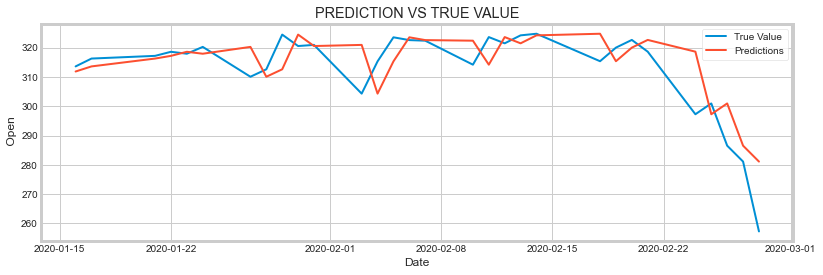

In [66]:
# show fig
plt.figure(figsize=(12,4))
sns.lineplot(df['Date'][-30:],df_test[' Open'], lw=2)
sns.lineplot(df['Date'][-30:],predictions, lw=2)
plt.legend(['True Value', 'Predictions'], bbox_to_anchor=(1, 1))
plt.title('PREDICTION VS TRUE VALUE')

#### R-SQUARED SCORE

In [67]:
nb_accu = r2_score(df_test[' Open'], predictions) *100
print('R-SQUARED SCORE:   ', round(nb_accu,2), '%')

R-SQUARED SCORE:    64.81 %


#### (MAE, MSE, RMSE)

In [68]:
nb_mae = mean_absolute_error(df_test[' Open'], predictions)
nb_mse = mean_squared_error(df_test[' Open'], predictions)
nb_rmse = np.sqrt(mean_squared_error(df_test[' Open'], predictions))

print('MAE:  ', nb_mae)
print('MSE:  ', nb_mse)
print('RMSE:  ', nb_rmse)

MAE:   6.266733333333328
MSE:   77.57621773333334
RMSE:   8.807736243401783


#### MEAN ABSOLUTE PERCENTAGE ERROR

In [69]:
nb_error_rate = abs(((df_test[' Open'] - predictions) / df_test[' Open'].values).mean()) * 100
print('MAPE: ', round(nb_error_rate,2), '%')

MAPE:  0.69 %


### MOVING AVERAGE
---

In [17]:
predictions = []
for i in range(df_test.shape[0]):
    if i == 0:
        predictions.append(np.mean(df_train[' Open'][-30:].values))
    if i < (len(df_test[' Open'])+1) and i > 0:
        predictions.append(0.5 * (np.mean(df_train[' Open'][-30+i:].values) + \
                                  np.mean(predictions[:i])))
    if i > (len(df_test[' Open'])+1):
        predictions.append(np.mean(predictions))

#### PREDICTION COMPARISSON TO ORIGINAL PRICE

Text(0.5, 1.0, 'PREDICTION VS TRUE VALUE')

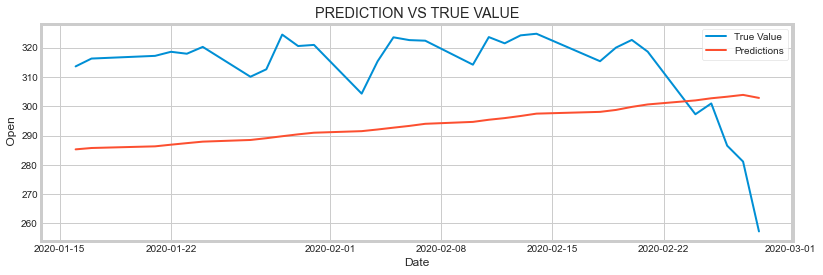

In [18]:
# show fig
plt.figure(figsize=(12,4))
sns.lineplot(df['Date'][-30:],df_test[' Open'], lw=2)
sns.lineplot(df['Date'][-30:],predictions, lw=2)
plt.legend(['True Value', 'Predictions'], bbox_to_anchor=(1, 1))
plt.title('PREDICTION VS TRUE VALUE')

#### R-SQUARED SCORE

In [19]:
mave_accu = r2_score(df_test[' Open'], predictions) *100
print('R-SQUARED SCORE:   ', round(mave_accu,2), '%')

R-SQUARED SCORE:    -215.31 %


#### (MAE, MSE, RMSE)

In [20]:
mave_mae = mean_absolute_error(df_test[' Open'], predictions)
mave_mse = mean_squared_error(df_test[' Open'], predictions)
mave_rmse = np.sqrt(mean_squared_error(df_test[' Open'], predictions))

print('MAE:  ', mave_mae)
print('MSE:  ', mave_mse)
print('RMSE:  ', mave_rmse)

MAE:   24.929047476270046
MSE:   695.0329585084032
RMSE:   26.36347773925897


#### MEAN ABSOLUTE PERCENTAGE ERROR

In [21]:
mave_error_rate = abs(((df_test[' Open'] - predictions) / df_test[' Open'].values).mean()) * 100
print('MAPE: ', round(mave_error_rate,2), '%')

MAPE:  5.73 %


### EXPONENTIAL SMOOTHING
---

In [22]:
predictions = []

fit = ExponentialSmoothing(np.asarray(df_train[' Open']) ,seasonal_periods=7,trend='add', seasonal='add',).fit()
predictions = fit.forecast(df_test.shape[0])

#### PREDICTION COMPARISSON TO ORIGINAL PRICE

Text(0.5, 1.0, 'PREDICTION VS TRUE VALUE')

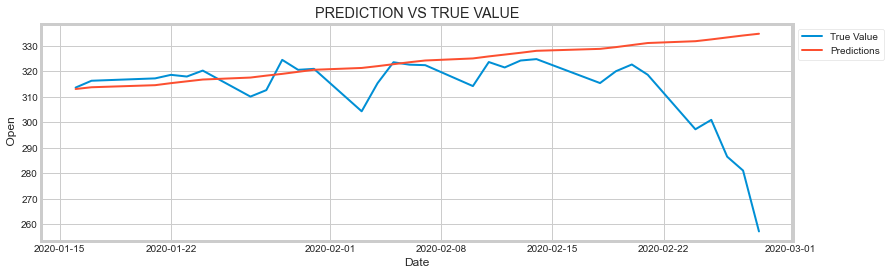

In [23]:
# show fig
plt.figure(figsize=(12,4))
sns.lineplot(df['Date'][-30:],df_test[' Open'], lw=2)
sns.lineplot(df['Date'][-30:],predictions, lw=2)
plt.legend(['True Value', 'Predictions'], bbox_to_anchor=(1, 1))
plt.title('PREDICTION VS TRUE VALUE')

#### R-SQUARED SCORE

In [24]:
es_accu = r2_score(df_test[' Open'], predictions) *100
print('R-SQUARED SCORE:   ', round(es_accu,2), '%')

R-SQUARED SCORE:    -116.24 %


#### (MAE, MSE, RMSE)

In [25]:
es_mae = mean_absolute_error(df_test[' Open'], predictions)
es_mse = mean_squared_error(df_test[' Open'], predictions)
es_rmse = np.sqrt(mean_squared_error(df_test[' Open'], predictions))

print('MAE:  ', es_mae)
print('MSE:  ', es_mse)
print('RMSE:  ', es_rmse)

MAE:   12.386843133051956
MSE:   476.66056968489164
RMSE:   21.832557561698803


#### MEAN ABSOLUTE PERCENTAGE ERROR

In [26]:
es_error_rate = abs(((df_test[' Open'] - predictions) / df_test[' Open'].values).mean()) * 100
print('MAPE: ', round(es_error_rate,2), '%')

MAPE:  3.81 %


### AUTO REGRESSIVE INTEGRATED MOVING AVERAGE (ARIMA)
---

In [44]:
predictions = []
fit = sm.tsa.statespace.SARIMAX(df_train[' Open'][-30:], order=(0,0,0), seasonal_order=(0,1,1,7)).fit()
predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape(30,)

#### PREDICTION COMPARISSON TO ORIGINAL PRICE


Text(0.5, 1.0, 'PREDICTION VS TRUE VALUE')

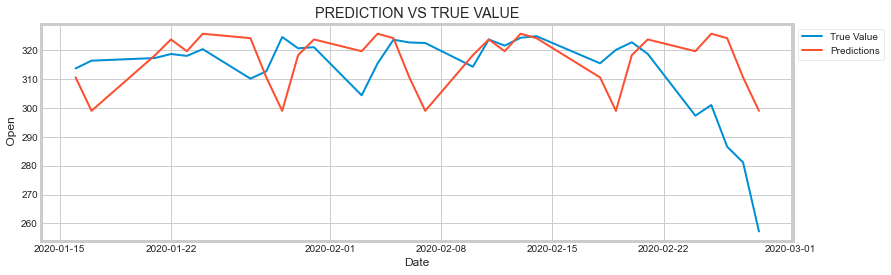

In [45]:
# show fig
plt.figure(figsize=(12,4))
sns.lineplot(df['Date'][-30:],df_test[' Open'], lw=2)
sns.lineplot(df['Date'][-30:],predictions, lw=2)
plt.legend(['True Value', 'Predictions'], bbox_to_anchor=(1, 1))
plt.title('PREDICTION VS TRUE VALUE')

#### R-SQUARED SCORE

In [46]:
arima_accu = r2_score(df_test[' Open'], predictions) *100
print('R-SQUARED SCORE:   ', round(arima_accu,2), '%')

R-SQUARED SCORE:    -19.62 %


#### (MAE, MSE, RMSE)

In [47]:
arima_mae = mean_absolute_error(df_test[' Open'], predictions)
arima_mse = mean_squared_error(df_test[' Open'], predictions)
arima_rmse = np.sqrt(mean_squared_error(df_test[' Open'], predictions))

print('MAE:  ', arima_mae)
print('MSE:  ', arima_mse)
print('RMSE:  ', arima_rmse)

MAE:   11.349691821428648
MSE:   263.67994471450515
RMSE:   16.23822480182194


#### MEAN ABSOLUTE PERCENTAGE ERROR

In [48]:
arima_error_rate = abs(((df_test[' Open'] - predictions) / df_test[' Open'].values).mean()) * 100
print('MAPE: ', round(arima_error_rate,2), '%')

MAPE:  1.32 %


### FBPROPHET
---

In [52]:
data = df_train[' Open'][-30:].values

df_ = pd.DataFrame()
df_['ds'], df_['y'] = df.Date[-30:].values,data
model = Prophet(daily_seasonality=True)
model.fit(df_)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
predictions = forecast['yhat'][30:].values

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


#### PLOTTING THE FORECAST

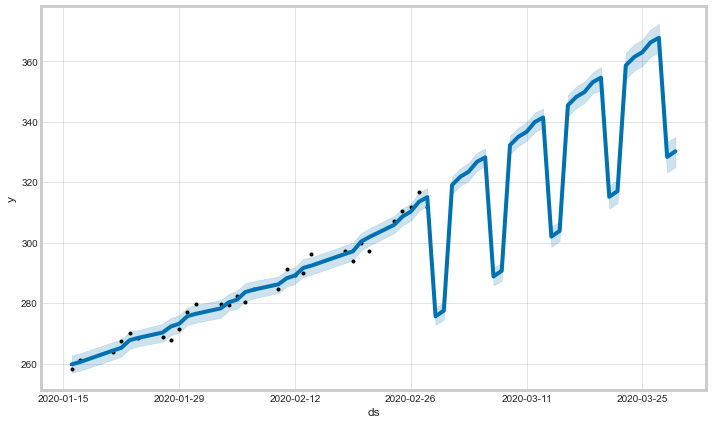

In [57]:
model.plot(forecast)
pyplot.show()

#### FBPROPHET COMPONENTS

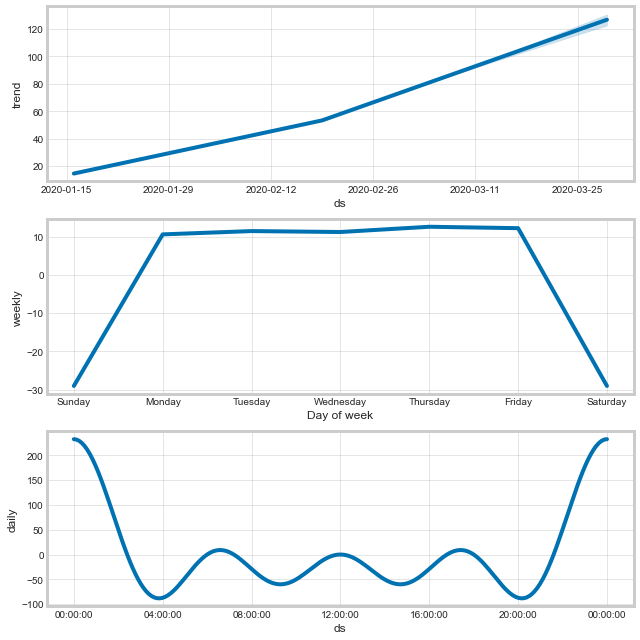

In [58]:
model.plot_components(forecast)
pyplot.show()

* The forecast and component visualizations show that Prophet was able to accurately model the underlying trend in the data, while also accurately modeling weekly and yearly seasonality. 
* Also, Open Stock Price are high from monday to friday than weekends.

#### FBPROPHET PREDICTION DATAFRAME

In [59]:
forecast.tail().T

55                   56  \
ds                          2020-03-25 00:00:00  2020-03-26 00:00:00   
trend                                   119.244              121.127   
yhat_lower                              358.422              361.528   
yhat_upper                              367.177              370.561   
trend_lower                              115.86              117.528   
trend_upper                             122.331              124.424   
additive_terms                          243.744              245.118   
additive_terms_lower                    243.744              245.118   
additive_terms_upper                    243.744              245.118   
daily                                   232.518              232.518   
daily_lower                             232.518              232.518   
daily_upper                             232.518              232.518   
weekly                                  11.2263              12.5998   
weekly_lower                            11.2263              12.5998   
weekly_upper                            11.2263              12.5998   
multiplicative_terms                          0                    0   
multiplicative_terms_lower                    0                    0   
multiplicative_terms_upper                    0                    0   
yhat                                    362.988              366.244   

                                             57                   58  \
ds                          2020-03-27 00:00:00  2020-03-28 00:00:00   
trend                                   123.009              124.892   
yhat_lower                              362.894              323.129   
yhat_upper                              372.363              333.448   
trend_lower                             119.225              120.839   
trend_upper                             126.524              128.597   
additive_terms                          244.746              203.453   
additive_terms_lower                    244.746              203.453   
additive_terms_upper                    244.746              203.453   
daily                                   232.518              232.518   
daily_lower                             232.518              232.518   
daily_upper                             232.518              232.518   
weekly                                  12.2283             -29.0647   
weekly_lower                            12.2283             -29.0647   
weekly_upper                            12.2283             -29.0647   
multiplicative_terms                          0                    0   
multiplicative_terms_lower                    0                    0   
multiplicative_terms_upper                    0                    0   
yhat                                    367.755              328.345   

                                             59  
ds                          2020-03-29 00:00:00  
trend                                   126.774  
yhat_lower                              325.055  
yhat_upper                              334.923  
trend_lower                             122.517  
trend_upper                              130.66  
additive_terms                          203.453  
additive_terms_lower                    203.453  
additive_terms_upper                    203.453  
daily                                   232.518  
daily_lower                             232.518  
daily_upper                             232.518  
weekly                                 -29.0648  
weekly_lower                           -29.0648  
weekly_upper                           -29.0648  
multiplicative_terms                          0  
multiplicative_terms_lower                    0  
multiplicative_terms_upper                    0  
yhat                                    330.227

In [60]:
#show yhat, ylower,yupper
forecast[['yhat','yhat_lower','yhat_upper']][:30].T

0           1           2           3           4   \
yhat        259.733698  260.501471  264.300798  265.195487  267.708016   
yhat_lower  256.934951  257.671197  261.305555  262.289271  264.879900   
yhat_upper  262.708580  263.401376  267.111085  267.958260  270.560595   

                    5           6           7           8           9   ...  \
yhat        268.475611  270.268938  272.274224  273.169294  275.682534  ...   
yhat_lower  265.665573  267.245806  269.367216  270.295589  272.768174  ...   
yhat_upper  271.081580  273.147728  275.084638  276.050852  278.637781  ...   

                    20          21          22          23          24  \
yhat        292.407641  296.209097  297.104855  300.355845  301.866907   
yhat_lower  289.468803  293.178942  294.204221  297.371692  299.061480   
yhat_upper  295.197441  299.022026  300.071969  303.132063  304.705726   

                    25          26          27          28          29  
yhat        305.890635  308.639388  310.277544  313.533540  315.044602  
yhat_lower  303.146487  305.723109  307.260409  310.522343  312.239490  
yhat_upper  308.855652  311.332570  312.954326  316.605421  318.045047  

[3 rows x 30 columns]

#### PREDICTION COMPARISSON TO ORIGINAL PRICE


Text(0.5, 1.0, 'PREDICTION VS TRUE VALUE')

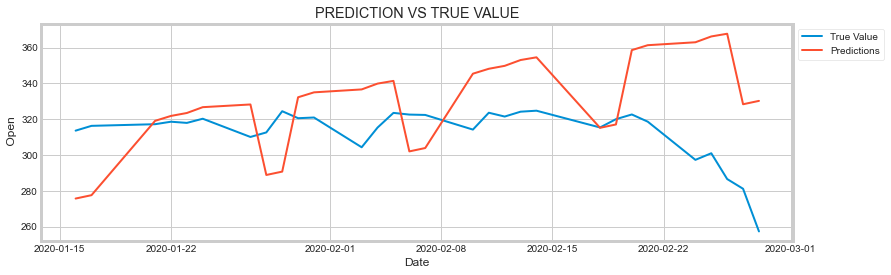

In [37]:
# show fig
plt.figure(figsize=(12,4))
sns.lineplot(df['Date'][-30:],df_test[' Open'], lw=2)
sns.lineplot(df['Date'][-30:],predictions, lw=2)
plt.legend(['True Value', 'Predictions'], bbox_to_anchor=(1, 1))
plt.title('PREDICTION VS TRUE VALUE')

#### R-SQUARED SCORE

In [61]:
fb_accu = r2_score(df_test[' Open'], predictions) *100
print('R-SQUARED SCORE:   ', round(fb_accu,2), '%')

R-SQUARED SCORE:    -476.26 %


#### (MAE, MSE, RMSE)

In [62]:
fb_mae = mean_absolute_error(df_test[' Open'], predictions)
fb_mse = mean_squared_error(df_test[' Open'], predictions)
fb_rmse = np.sqrt(mean_squared_error(df_test[' Open'], predictions))

print('MAE:  ', fb_mae)
print('MSE:  ', fb_mse)
print('RMSE:  ', fb_rmse)

MAE:   28.878026532743164
MSE:   1270.236655052115
RMSE:   35.64037955819375


#### MEAN ABSOLUTE PERCENTAGE ERROR

In [63]:
fb_error_rate = abs(((df_test[' Open'] - predictions) / df_test[' Open'].values).mean()) * 100
print('MAPE: ', round(fb_error_rate,2), '%')

MAPE:  5.8 %


## MODEL COMPARISSON
---

In [437]:
#This is a error percentage comaparisson for classical statistics forecasting method

### COMPARISSON BY MAPE

In [70]:
models = ['Naive Apporoach', 'Moving Average', 'Exponential Smoothing',
          'ARIMA', 'FBProphet']
mape_model = [nb_error_rate, mave_error_rate, es_error_rate, arima_error_rate, fb_error_rate]

Text(0, 0.5, 'Error %')

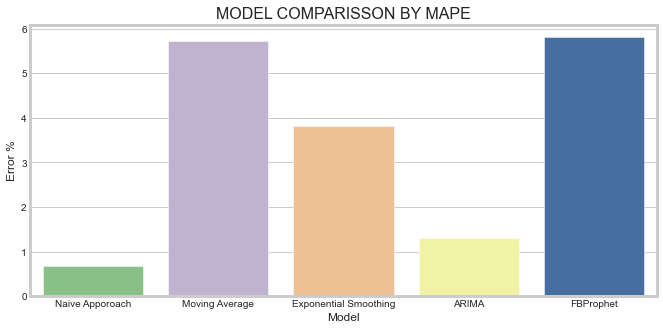

In [73]:
plt.figure(figsize=(10,5))
sns.barplot(x=models, y=mape_model, palette='Accent')
plt.title('MODEL COMPARISSON BY MAPE', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Error %', fontsize=12)

* NAIVE APPROACH HAS THE LOWEST ERROR PERCENTAGE HERE
* FBPROPHET HAS THE HIGHEST PERCENTAGE ERROR, BUT WE CAN LOWER THAT BY MODIFYING THE HYPERPARAMETERS.
* AS FOR ARIMA, WE CAN ALSO IMPROVE THE MODEL BY HAVING THE RIGHT PARAMETERS

### COMPARISSON BY MAE, MSE AND RMSE

In [74]:
metrics = pd.DataFrame(index=models, columns=['MAE', 'MSE', 'RMSE'])
mae = [nb_mae,mave_mae,es_mae,arima_mae,fb_mae]
mse = [nb_mse,mave_mse,es_mse,arima_mse,fb_mse]
rmse = [nb_rmse,mave_rmse,es_rmse,arima_rmse,fb_rmse]

metrics['MAE'] = mae
metrics['MSE'] = mse
metrics['RMSE'] = rmse

In [75]:
metrics

MAE          MSE       RMSE
Naive Apporoach         6.266733    77.576218   8.807736
Moving Average         24.929047   695.032959  26.363478
Exponential Smoothing  12.386843   476.660570  21.832558
ARIMA                  11.349692   263.679945  16.238225
FBProphet              28.878027  1270.236655  35.640380

## MACHINE LEARNING PREDICTIVE MODELLING
---

In [450]:
#setting up bayes optimization for hyperparameters

In [78]:
df_train.columns = ['price','day','week','month','year']
df_test.columns = ['price','day','week','month','year']

X_train = df_train.drop('price',axis=1)
y_train = df_train['price']

X_test = df_test.drop('price',axis=1)
y_test = df_test['price']

In [79]:
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test)

### XGBOOST WITH BAYESIAN OPTIMIZATION
---

In [80]:
#bayesian hyper parameter tuning
#define the params
def xgb_evaluate(max_depth, gamma, colsample_bytree):
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree}
    
    cv_result = xgb.cv(params, dtrain, num_boost_round=250, nfold=3)    
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [81]:
#run optimizer
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 0.9)})
#define iter points
xgb_bo.maximize(init_points=10, n_iter=15, acq='ei')

|   iter    |  target   | colsam... |   gamma   | max_depth |
-------------------------------------------------------------
|  1        | -3.845    |  0.8772   |  0.3864   |  5.169    |
|  2        | -12.6     |  0.414    |  0.2453   |  4.316    |
|  3        | -12.61    |  0.3466   |  0.1664   |  6.336    |
|  4        | -6.516    |  0.711    |  0.4376   |  4.945    |
|  5        | -5.317    |  0.7391   |  0.7472   |  5.132    |
|  6        | -6.525    |  0.6706   |  0.5483   |  4.33     |
|  7        | -5.024    |  0.5739   |  0.5713   |  6.89     |
|  8        | -6.535    |  0.6243   |  0.6306   |  4.73     |
|  9        | -12.61    |  0.3956   |  0.2409   |  6.982    |
|  10       | -12.61    |  0.4416   |  0.04156  |  6.015    |
|  11       | -5.356    |  0.6465   |  0.6816   |  5.439    |
|  12       | -4.406    |  0.8275   |  0.9543   |  4.231    |
|  13       | -12.6     |  0.4125   |  0.4588   |  3.082    |
|  14       | -5.313    |  0.5013   |  0.4217   |  5.603    |
|  15   

In [82]:
#get the best parameters
params = xgb_bo.max['params']
params['max_depth'] = int(round(params['max_depth']))

In [83]:
#train the model
model = xgb.train(params, dtrain, num_boost_round=100)

In [84]:
#get predictions
predictions = model.predict(dtest)

Text(0.5, 1.0, 'PREDICTION VS TRUE VALUE')

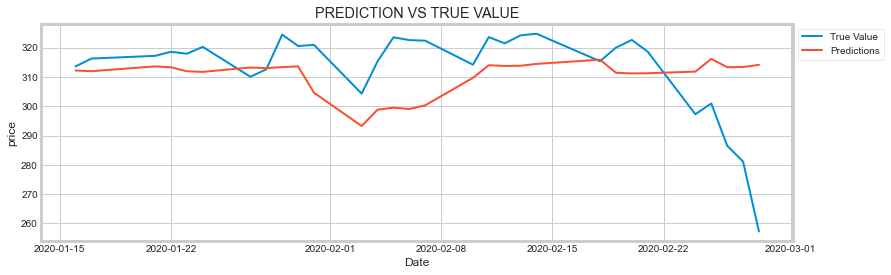

In [89]:
# show fig
plt.figure(figsize=(12,4))
sns.lineplot(df['Date'][-30:],df_test['price'], lw=2)
sns.lineplot(df['Date'][-30:],predictions, lw=2)
plt.legend(['True Value', 'Predictions'], bbox_to_anchor=(1, 1))
plt.title('PREDICTION VS TRUE VALUE')

#### R-SQUARED SCORE

In [90]:
xgb_accu = r2_score(df_test['price'], predictions) *100
print('R-SQUARED SCORE:   ', round(xgb_accu,2), '%')

R-SQUARED SCORE:    -31.71 %


#### (MAE, MSE, RMSE)

In [91]:
xgb_mae = mean_absolute_error(df_test['price'], predictions)
xgb_mse = mean_squared_error(df_test['price'], predictions)
xgb_rmse = np.sqrt(mean_squared_error(df_test['price'], predictions))

print('MAE:  ', xgb_mae)
print('MSE:  ', xgb_mse)
print('RMSE:  ', xgb_rmse)

MAE:   12.677804435221354
MSE:   290.31512113379097
RMSE:   17.038636128921556


In [92]:
xgb_error_rate = abs(((df_test['price'] - predictions) / df_test['price'].values).mean()) * 100
print('MAPE: ', round(xgb_error_rate,2), '%')

MAPE:  0.59 %


### XGBRGRESSOR WITH HYPERPARAMETER TUNING WITH RANDOM SEARCH
---

In [93]:
#RandomSearchCV
# Hyperparameters to tune and their ranges
param_dist = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10)}

rs = RandomizedSearchCV(XGBRegressor(), param_distributions=param_dist, 
                        scoring='neg_mean_squared_error', n_iter=25)

# Run random search for 25 iterations
rs.fit(X_train, y_train);

In [94]:
predictions = rs.predict(X_test)

Text(0.5, 1.0, 'PREDICTION VS TRUE VALUE')

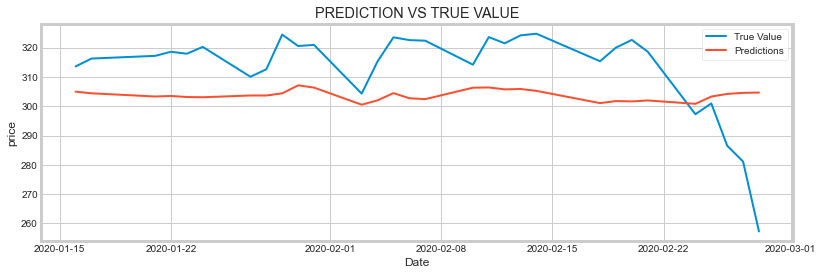

In [95]:
# show fig
plt.figure(figsize=(12,4))
sns.lineplot(df['Date'][-30:],df_test['price'], lw=2)
sns.lineplot(df['Date'][-30:],predictions, lw=2)
plt.legend(['True Value', 'Predictions'], bbox_to_anchor=(1, 1))
plt.title('PREDICTION VS TRUE VALUE')

#### R-SQUARED SCORE

In [96]:
xgbreg_accu = r2_score(y_test, predictions) *100
print('R-SQUARED SCORE:   ', round(xgbreg_accu,2), '%')

R-SQUARED SCORE:    -37.81 %


#### (MAE, MSE, RMSE)

In [97]:
xgbreg_mae = mean_absolute_error(df_test['price'], predictions)
xgbreg_mse = mean_squared_error(df_test['price'], predictions)
xgbreg_rmse = np.sqrt(mean_squared_error(df_test['price'], predictions))

print('MAE:  ', xgbreg_mae)
print('MSE:  ', xgbreg_mse)
print('RMSE:  ', xgbreg_rmse)

MAE:   15.464148551432293
MSE:   303.7679302787495
RMSE:   17.4289394479053


#### MEAN ABSOLUTE PERCENTAGE ERROR

In [100]:
xgbreg_error_rate = abs(((df_test['price'] - predictions) / df_test['price'].values).mean()) * 100
print('MAPE: ', round(xgbreg_error_rate,2), '%')

MAPE:  2.69 %


### INSIGHTS
---
* Both XGBoost and  XGBRegressor really have some similarities, even though they've used different optimization techniques.
* They did pretty well when predicting the trend, except for the last 10 days of forecast where the the price of stocks began to fall because of pandemic.